In [1]:
import pandas as pd
import numpy as np
import pingouin as pg
import matplotlib.pyplot as plt
import matplotlib
import plot_likert

In [2]:
# Load the data
df = pd.read_csv("KlimaatHelpdesk_20240105.csv", header=0, skiprows=[1, 2])

In [3]:
# Rename some of the columns, and swap the Likert scale of some of the questions
df = df.rename(columns={'Random': 'Condition'})

df = df.replace({'Q2': {'Vrouw': 'Woman', 'Man': 'Man', 'Anders': 'Other'}})
mapping = {'Helemaal oneens': 1, 'Helemaal niet mee eens': 1, 'Helemaal niet eens': 1, 'Heel onwaarschijnlijk': 1,
           'Niet eens': 2, 'Niet mee eens': 2, 'Onwaarschijnlijk': 2,
           'Neutraal': 3,
           'Eens': 4, 'Mee eens': 4, 'Waarschijnlijk': 4,
           'Helemaal eens': 5, 'Helemaal mee eens': 5, 'Heel waarschijnlijk': 5,
}
mapping_cols_5 = ['Q4_1', 'Q4_2',
                'Q5_1', 'Q5_2', 'Q5_3', 'Q7_1', 'Q7_2',
                'Q7_3', 'Q7_4', 'Q7_5', 'Q7_6',
                'Q11_1', 'Q11_2', 'Q11_3', 'Q11_4'
]
for c in mapping_cols_5:
    df = df.replace({c: mapping})

mapping_7 = {'Helemaal niet mee eens': 1, 'Niet mee eens': 2, 'Een beetje oneens': 3, 'Neutraal': 4, 'Een beetje eens': 5, 'Mee eens': 6, 'Helemaal mee eens': 7}
for c in [f"Q13_{v}" for v in range(1, 5)]:
    df = df.replace({c: mapping_7})

# order_swaps_10 = ["Q9_2", "Q9_3", "Q9_5", "Q9_7"]
order_swaps_10 = ["Q9_1", "Q9_4", "Q9_6", "Q9_8"]
for c in order_swaps_10:
    df[c] = 11 - df[c]

order_swaps_7 = ["Q12_6", "Q12_7"]
for c in order_swaps_7:
    df[c] = 8 - df[c]

In [4]:
# Define which groupings to plot

Conditions = ['', 'Logical scientific', 'Slightly personalized', 'Highly Personalized']
plot_groupings = ['Condition', 'SCT_gt4'] #, 'byplane']
figwidth = 12  # set the width for all Figures

In [5]:
# Filter for completed questionaires

# remove non-agreement
df.drop(df[df.Toestemming == 'nee'].index, inplace=True)

# remove non-100% completed cases
df.drop(df[df.Progress<100].index, inplace=True)
print(f"Records after non-100% complete: {len(df)}")

# remove short cases
df.drop(df[df["Duration (in seconds)"]<4*60].index, inplace=True)
df.drop(df[df["Duration (in seconds)"]>30*60].index, inplace=True)
print(f"Records after removing short and long: {len(df)}")

# remove users younger than 18 or older than 35
df.drop(df[df.Q1<1988].index, inplace=True)
df.drop(df[df.Q1>2005].index, inplace=True)
print(f"Records after removing young and old: {len(df)}")

print(f"Responses collected between {df.EndDate.min()} and {df.EndDate.max()}")


Records after non-100% complete: 169
Records after removing short and long: 104
Records after removing young and old: 100
Responses collected between 2023-06-20 02:30:28 and 2024-01-04 08:08:18


In [6]:
# Print some statistics of participants

# group by gender
print(df.groupby("Q2").size().to_string())

# group by condition
print(df.groupby("Condition").size().to_string())

# average age of the participants
print(f'Age: M={2023-df.Q1.mean():.0f}, SD={df.Q1.std():.1f}')

# average length of questionaire filling
print(f'Time needed to fill in questionaire: M={df["Duration (in seconds)"].mean()/60:.1f}, SD={df["Duration (in seconds)"].std()/60:.1f} minutes')

Q2
Man      44
Other     1
Woman    55
Condition
1    40
2    30
3    30
Age: M=24, SD=2.8
Time needed to fill in questionaire: M=8.0, SD=3.9 minutes


Number of holidays: median=2
Number of plane holidays: median=1
byplane
True     56
False    44
Likelihood to take airplane: M=4.4, SD=0.9, median=Very likely
Likelihood to take train: M=2.4, SD=0.9, median=Unlikely


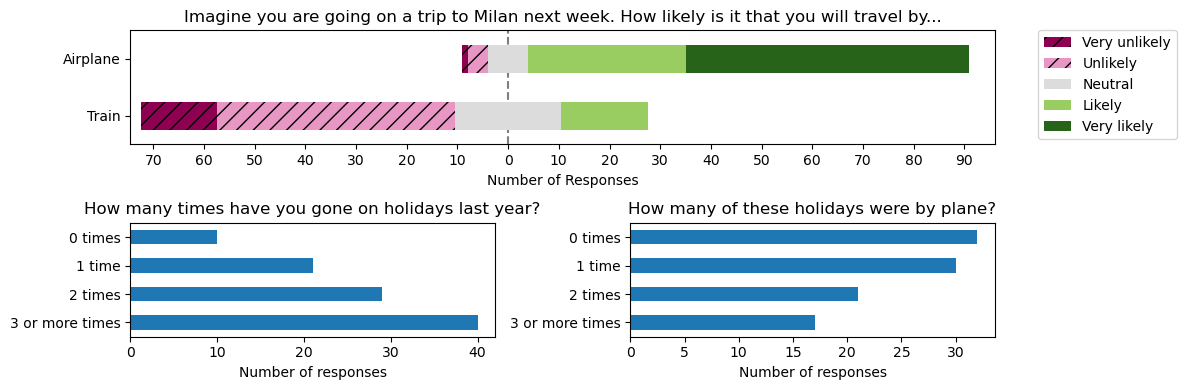

In [7]:
# Create Figure 1
fig = plt.figure(figsize=(figwidth, 4))
gs = matplotlib.gridspec.GridSpec(2, 2, figure=fig)
ax1 = fig.add_subplot(gs[0, :])
ax2 = fig.add_subplot(gs[1, 0])
ax3 = fig.add_subplot(gs[1, 1])

cmap = matplotlib.colormaps['PiYG']
colors = ["#ffffff00"] + [cmap(i) for i in np.linspace(0, 1, 5)]
colors[3] = "gainsboro"

likert_labels = ['Very unlikely', 'Unlikely', 'Neutral', 'Likely', 'Very likely']
data = pd.DataFrame([df[f"Q4_{v}"] for v in [1, 2]]).T
data.columns = ['Airplane', 'Train']
df["byplane"] = df["Q4_1"] >=5

a = plot_likert.plot_likert(data, [1.0, 2.0, 3.0, 4.0, 5.0], ax=ax1, colors=colors)
# adding hatches to the 'negative' bars
bars = [thing for thing in a.containers if isinstance(thing, matplotlib.container.BarContainer)]
for bar in bars[1:3]:
    for patch in bar:
        patch.set_hatch("//")

ax1.set_title("Imagine you are going on a trip to Milan next week. How likely is it that you will travel by...")
handles, labels = ax1.get_legend_handles_labels()
ax1.legend(handles, likert_labels, bbox_to_anchor=(1.05, 1), loc='upper left', borderaxespad=0.)

# number of (plane holidays)
print(f'Number of holidays: median={df.Q6.str[0].astype(int).median():.0f}')
print(f'Number of plane holidays: median={df.Q21.str[0].astype(int).median():.0f}')
print(df["byplane"].value_counts().to_string())

# likelihood of plane/train to Milan
print(f'Likelihood to take airplane: M={df.Q4_1.mean():.1f}, SD={df.Q4_1.std():.1f}, median={likert_labels[int(df.Q4_1.median())-1]}')
print(f'Likelihood to take train: M={df.Q4_2.mean():.1f}, SD={df.Q4_2.std():.1f}, median={likert_labels[int(df.Q4_2.median())-1]}')

qtitle ={'Q6': 'How many times have you gone on holidays last year?', 'Q21': 'How many of these holidays were by plane?'}
for q, ax in zip(['Q6', 'Q21'], [ax2, ax3]):
    data = pd.DataFrame(df[q].value_counts().loc[['0 keer', '1 keer', '2 keer', '3 keer of meer']])
    data.plot.barh(ax=ax)

    ax.get_legend().remove()
    ax.set_yticklabels(['0 times', '1 time', '2 times', '3 or more times'])
    ax.set_title(qtitle[q])
    ax.set_xlabel("Number of responses")
    ax.invert_yaxis()
    ax.yaxis.label.set_visible(False)
plt.tight_layout()
plt.show()

Science Capital: M=3.7, SD=0.8
Science Trust: M=4.0, SD=0.6
Science Capital and Trust Cronbach-Alpha: 0.79
SCT_gt4
False    53
True     47


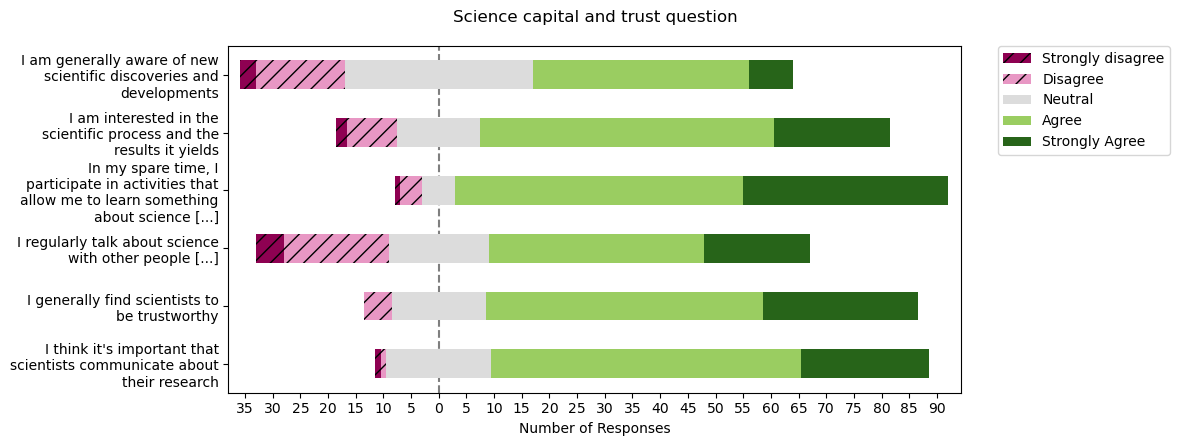

In [8]:
df["SC"] = df[[f"Q7_{v}" for v in range(1, 5)]].mean(axis=1)
print(f'Science Capital: M={df.SC.mean():.1f}, SD={df.SC.std():.1f}')

df["ST"] = df[[f"Q7_{v}" for v in range(5, 7)]].mean(axis=1)
print(f'Science Trust: M={df.ST.mean():.1f}, SD={df.ST.std():.1f}')
ca = pg.cronbach_alpha(df[[f"Q7_{v}" for v in range(1, 7)]])
print(f"Science Capital and Trust Cronbach-Alpha: {ca[0]:.2f}")

df["SCT_gt4"] = df[[f"Q7_{v}" for v in range(1, 7)]].mean(axis=1) >=4

print(df["SCT_gt4"].value_counts().to_string())

# Create Figure 2
fig, ax = plt.subplots(1, 1, figsize=(figwidth, 4.5))

cmap = matplotlib.colormaps['PiYG']
colors = ["#ffffff00"] + [cmap(i) for i in np.linspace(0, 1, 5)]
colors[3] = "gainsboro"

likert_labels = ['Strongly disagree', 'Disagree', 'Neutral', 'Agree', 'Strongly Agree']
data = pd.DataFrame([df[f"Q7_{v}"] for v in range(1, 7)]).T
data.columns = ['I am generally aware of new scientific discoveries and developments',
                'I am interested in the scientific process and the results it yields',
                'In my spare time, I participate in activities that allow me to learn something about science [...]',
                'I regularly talk about science with other people [...]',
                'I generally find scientists to be trustworthy',
                "I think it's important that scientists communicate about their research"]

a = plot_likert.plot_likert(data, [1.0, 2.0, 3.0, 4.0, 5.0], ax=ax, colors=colors)
# adding hatches to the 'negative' bars
bars = [thing for thing in a.containers if isinstance(thing, matplotlib.container.BarContainer)]
for bar in bars[1:3]:
    for patch in bar:
        patch.set_hatch("//")

handles, labels = ax.get_legend_handles_labels()
ax.legend(handles, likert_labels, bbox_to_anchor=(1.05, 1), loc='upper left', borderaxespad=0.)

plt.suptitle("Science capital and trust question")
plt.tight_layout()
plt.show()

Q8_1 (Professional/Personal): 0.003 (*)
Logical scientific vs Slightly personalized: 0.021 (*)
Logical scientific vs Highly Personalized: 0.008 (*)
Slightly personalized vs Highly Personalized: 0.492
Q8_2 (Formal/Informal): 0.010 (*)
Logical scientific vs Slightly personalized: 0.035 (*)
Logical scientific vs Highly Personalized: 0.030 (*)
Slightly personalized vs Highly Personalized: 0.515
Q8_1 (Professional/Personal): 0.255
Q8_2 (Formal/Informal): 0.908


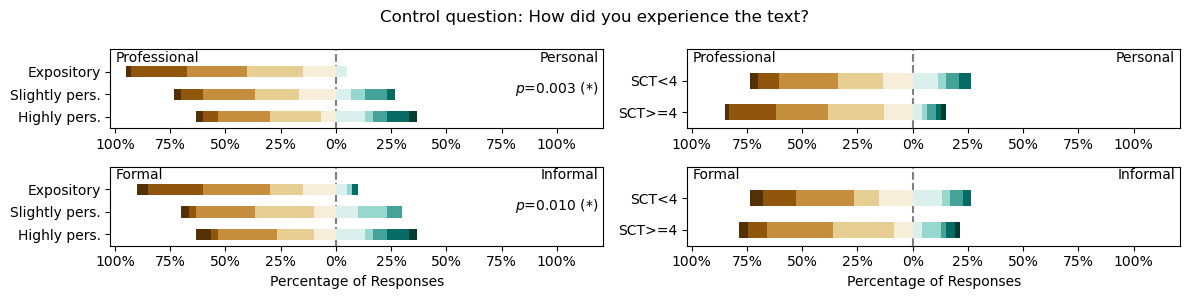

In [9]:
# Create Figure 3
fig, ax = plt.subplots(2, len(plot_groupings), figsize=(figwidth, 3))
question = "Q8"
subqs = range(1, 3)

scales = [['Professional', 'Personal'], ['Formal', 'Informal']]
cmap = matplotlib.colormaps['BrBG']
colors = ["#ffffff00"] + [cmap(i) for i in np.linspace(0, 1, 10)]

for j, condition in enumerate(plot_groupings):
    for i, v in enumerate(subqs):
        if condition == 'SCT_gt4':
            data = pd.DataFrame([df[f"{question}_{v}"].where(df[condition]==b) for b in [False, True]]).T
            data.columns = ['SCT<4', 'SCT>=4']
            maxy =2
        elif condition == 'byplane':
            data = pd.DataFrame([df[f"{question}_{v}"].where(df[condition]==b) for b in [True, False]]).T
            data.columns = ['Plane very likely', 'Others']
            maxy =2
        elif condition == 'Condition':
            data = pd.DataFrame([df[f"{question}_{v}"].where(df["Condition"]==c) for c in range(1, 4)]).T
            data.columns = ['Expository', 'Slightly pers.', 'Highly pers.']
            maxy =3

        plot_likert.plot_likert(data, [1.0, 2.0, 3.0, 4.0, 5.0, 6.0, 7.0, 8.0, 9.0, 10.0], ax=ax[i, j], colors=colors, plot_percentage=True, xtick_interval=25, pad_100=True)

        ax[i, j].set_ylim([-0.5, maxy])
        ax[i, j].text(0.01, 0.98, scales[i][0], transform=ax[i, j].transAxes, ha='left', va='top')
        ax[i, j].text(0.99, 0.98, scales[i][1], transform=ax[i, j].transAxes, ha='right', va='top')
        ax[i, j].get_legend().remove()
        ax[i, j].set_xlabel("")

        aov = pg.anova(dv=f"{question}_{v}", between=condition, data=df, detailed=False)
        pval = aov['p-unc'].mean()
        if pval < 0.05:
            ax[i, j].text(0.99, 0.5, f"$p$={pval:.3f} (*)", transform=ax[i, j].transAxes, ha='right', va='center')
            # ax[i, j].set_title(f"$p$={pval:.3f} (*)")
        star = ' (*)' if pval < 0.05 else ''
        print(f"{question}_{v} ({scales[i][0]}/{scales[i][1]}): {pval:.3f}{star}")

        if condition == 'Condition' and pval<0.05:
            pt = pg.pairwise_tests(dv=f"{question}_{v}", between=condition, padjust='holm',
                                alternative='two-sided', data=df)
            for i, row in pt.iterrows():
                pval = row['p-corr']
                star = ' (*)' if pval < 0.05 else ''
                print(f"{Conditions[row['A']]} vs {Conditions[row['B']]}: {pval:.3f}{star}")

    ax[-1, j].set_xlabel("Percentage of Responses")

plt.suptitle("Control question: How did you experience the text?")
plt.tight_layout()
plt.show()



Q9_1 (Unhappy/Happy): 0.021 (*)
Logical scientific vs Slightly personalized: 0.040 (*)
Logical scientific vs Highly Personalized: 0.662
Slightly personalized vs Highly Personalized: 0.048 (*)
Q9_2 (Annoyed/Pleased): 0.143
Q9_3 (Despairing/Hopeful): 0.420
Q9_4 (Unsatisfied/Satisfied): 0.154
Q9_5 (Relaxed/Thrilled): 0.266
Q9_6 (Dull/Full of energy): 0.188
Q9_7 (Calm/Excited): 0.785
Q9_8 (Not Interesting/Interesting): 0.682
Emotion separated by Condition: 0.305
Q9_1 (Unhappy/Happy): 0.022 (*)
Q9_2 (Annoyed/Pleased): 0.435
Q9_3 (Despairing/Hopeful): 0.448
Q9_4 (Unsatisfied/Satisfied): 0.034 (*)
Q9_5 (Relaxed/Thrilled): 0.204
Q9_6 (Dull/Full of energy): 0.117
Q9_7 (Calm/Excited): 0.809
Q9_8 (Not Interesting/Interesting): 0.021 (*)
Emotion separated by SCT_gt4: 0.011 (*)


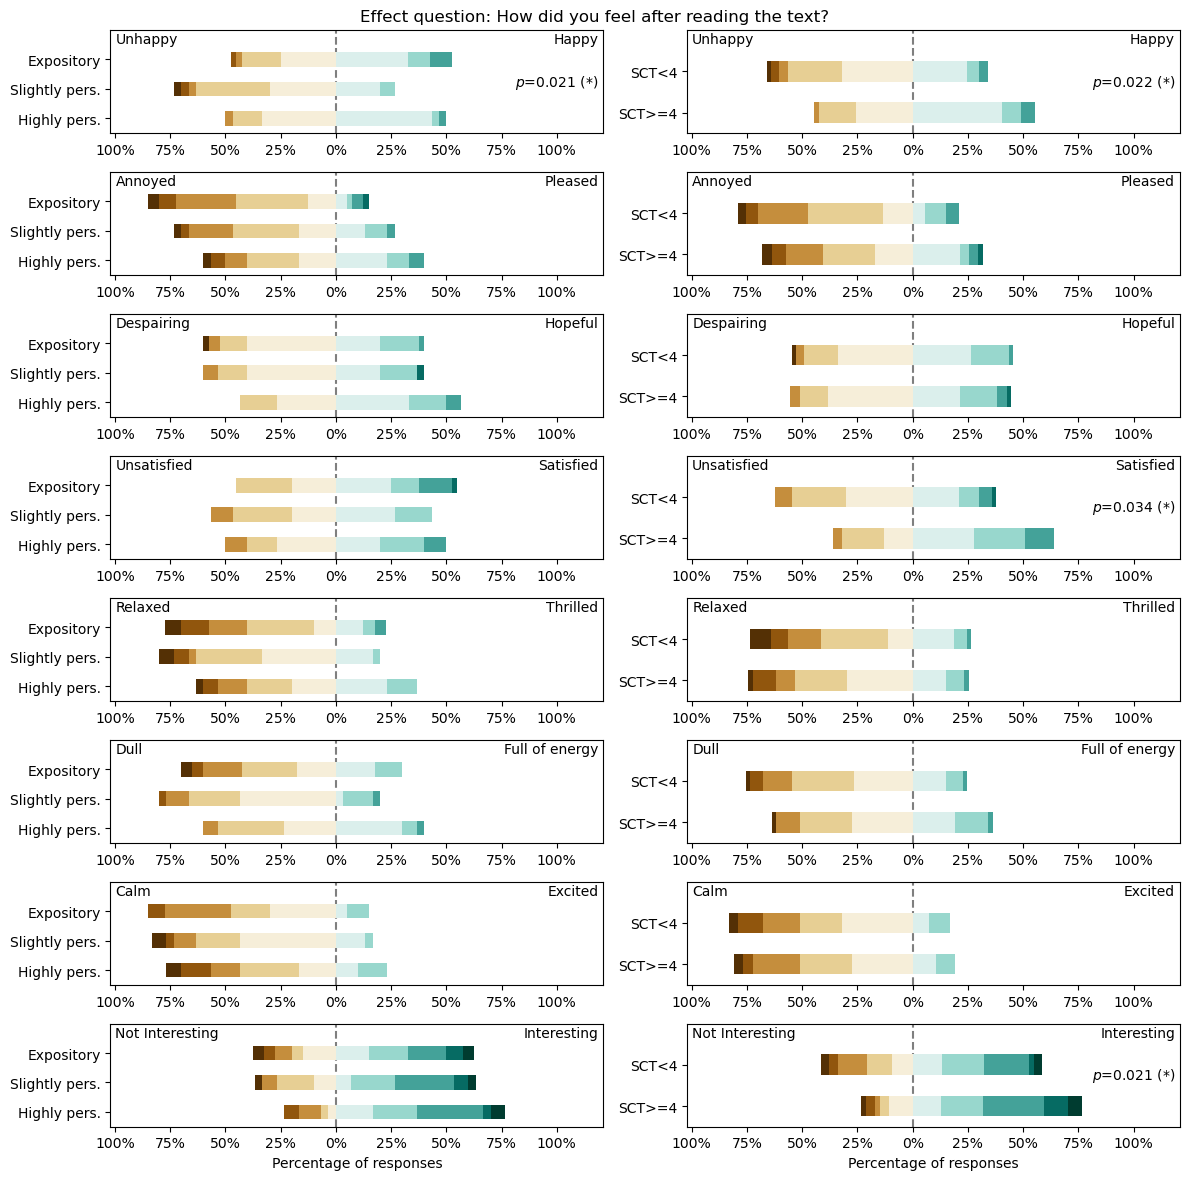

Emotion Cronbach-Alpha: 0.69


In [10]:
# Create Figure 4
fig, ax = plt.subplots(8, len(plot_groupings), figsize=(figwidth, 12))
question = "Q9"
subqs = range(1, 9)

scales = [['Unhappy', 'Happy'],
          ['Annoyed', 'Pleased'],
          ['Despairing', 'Hopeful'],
          ['Unsatisfied', 'Satisfied'],
          ['Relaxed', 'Thrilled'],
          ['Dull', 'Full of energy'],
          ['Calm', 'Excited'],
          ['Not Interesting', 'Interesting']]

cmap = matplotlib.colormaps['BrBG']
colors = ["#ffffff00"] + [cmap(i) for i in np.linspace(0, 1, 10)]

for j, condition in enumerate(plot_groupings):
    for i, v in enumerate(subqs):
        if condition == 'SCT_gt4':
            data = pd.DataFrame([df[f"{question}_{v}"].where(df[condition]==b) for b in [False, True]]).T
            data.columns = ['SCT<4', 'SCT>=4']
            maxy =2
        elif condition == 'byplane':
            data = pd.DataFrame([df[f"{question}_{v}"].where(df[condition]==b) for b in [True, False]]).T
            data.columns = ['Plane very likely', 'Others']
            maxy =2
        elif condition == 'Condition':
            data = pd.DataFrame([df[f"{question}_{v}"].where(df["Condition"]==c) for c in range(1, 4)]).T
            data.columns = ['Expository', 'Slightly pers.', 'Highly pers.']
            maxy =3

        plot_likert.plot_likert(data, [1.0, 2.0, 3.0, 4.0, 5.0, 6.0, 7.0, 8.0, 9.0, 10.0], ax=ax[i, j], colors=colors, plot_percentage=True, xtick_interval=25, pad_100=True)

        ax[i, j].set_ylim([-0.5, maxy])
        ax[i, j].text(0.01, 0.98, scales[i][0], transform=ax[i, j].transAxes, ha='left', va='top')
        ax[i, j].text(0.99, 0.98, scales[i][1], transform=ax[i, j].transAxes, ha='right', va='top')
        ax[i, j].get_legend().remove()
        ax[i, j].set_xlabel("")

        ax[-1, j].set_xlabel("Percentage of responses")

        aov = pg.anova(dv=f"{question}_{v}", between=condition, data=df, detailed=False)
        pval = aov['p-unc'].mean()
        if pval < 0.05:
            ax[i, j].text(0.99, 0.5, f"$p$={pval:.3f} (*)", transform=ax[i, j].transAxes, ha='right', va='center')
        star = ' (*)' if pval < 0.05 else ''
        print(f"{question}_{v} ({scales[i][0]}/{scales[i][1]}): {pval:.3f}{star}")

        if condition == 'Condition' and pval<0.05:
            pt = pg.pairwise_tests(dv=f"{question}_{v}", between=condition, padjust='holm',
                                alternative='two-sided', data=df)
            for i, row in pt.iterrows():
                pval = row['p-corr']
                star = ' (*)' if pval < 0.05 else ''
                print(f"{Conditions[row['A']]} vs {Conditions[row['B']]}: {pval:.3f}{star}")

    df["Emotion"] = df[[f"{question}_{v}" for v in subqs]].mean(axis=1)
    aov = pg.anova(dv="Emotion", between=condition, data=df, detailed=False)
    pval = aov['p-unc'].mean()
    star = ' (*)' if pval < 0.05 else ''
    print(f"Emotion separated by {condition}: {pval:.3f}{star}")

plt.suptitle("Effect question: How did you feel after reading the text?")
plt.tight_layout()
plt.show()
ca = pg.cronbach_alpha(df[[f"{question}_{v}" for v in subqs]])
print(f"Emotion Cronbach-Alpha: {ca[0]:.2f}")


Q11_1: 0.370
Q11_2: 0.305
Q11_3: 0.275
Q11_4: 0.572
Q11_1: 0.370
Q11_2: 0.305
Q11_3: 0.275
Q11_4: 0.572


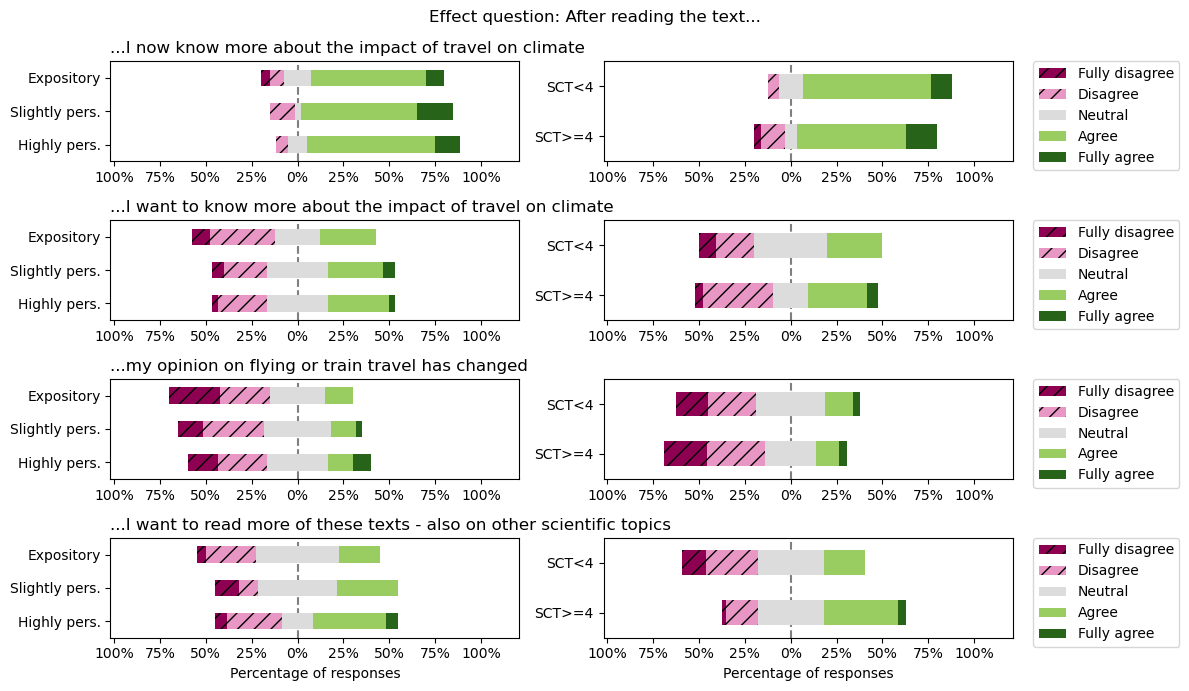

In [11]:
# Create Figure 5
fig, ax = plt.subplots(4, len(plot_groupings), figsize=(figwidth, 7))
question = "Q11"
subqs = range(1, 5)

likert_labels = ['Fully disagree', 'Disagree', 'Neutral', 'Agree', 'Fully agree']
titles = ['...I now know more about the impact of travel on climate',
          '...I want to know more about the impact of travel on climate',
          '...my opinion on flying or train travel has changed',
          '...I want to read more of these texts - also on other scientific topics']

cmap = matplotlib.colormaps['PiYG']
colors = ["#ffffff00"] + [cmap(i) for i in np.linspace(0, 1, 5)]
colors[3] = "gainsboro"

for j, condition in enumerate(plot_groupings):
    for i, v in enumerate(subqs):
        if condition == 'SCT_gt4':
            data = pd.DataFrame([df[f"{question}_{v}"].where(df[condition]==b) for b in [False, True]]).T
            data.columns = ['SCT<4', 'SCT>=4']
            maxy =2
        elif condition == 'byplane':
            data = pd.DataFrame([df[f"{question}_{v}"].where(df[condition]==b) for b in [True, False]]).T
            data.columns = ['Plane very likely', 'Others']
            maxy =2
        elif condition == 'Condition':
            data = pd.DataFrame([df[f"{question}_{v}"].where(df["Condition"]==c) for c in range(1, 4)]).T
            data.columns = ['Expository', 'Slightly pers.', 'Highly pers.']
            maxy =3

        a = plot_likert.plot_likert(data, [1.0, 2.0, 3.0, 4.0, 5.0], ax=ax[i, j], colors=colors, plot_percentage=True, xtick_interval=25, pad_100=True)
        # adding hatches to the 'negative' bars
        bars = [thing for thing in a.containers if isinstance(thing, matplotlib.container.BarContainer)]
        for bar in bars[1:3]:
            for patch in bar:
                patch.set_hatch("//")

        if j == 0:
            ax[i, j].set_title(titles[i], loc='left')
        handles, labels = ax[i, j].get_legend_handles_labels()
        if j == len(plot_groupings)-1:
            ax[i, j].legend(handles, likert_labels, bbox_to_anchor=(1.05, 1), loc='upper left', borderaxespad=0.)
        else:
            ax[i, j].get_legend().remove()
        ax[i, j].set_xlabel("")

        aov = pg.anova(dv=f"{question}_{v}", between='Condition', data=df, detailed=False)
        pval = aov['p-unc'].mean()
        star = ' (*)' if pval < 0.05 else ''
        print(f"{question}_{v}: {pval:.3f}{star}")

    ax[-1, j].set_xlabel("Percentage of responses")

plt.suptitle("Effect question: After reading the text...")
plt.tight_layout()
plt.show()

Q12_1 (Not at all competent/Very competent): 0.189
Q12_2 (Not at all expert/Very expert): 0.942
Q12_3 (Not at all intelligent/Very intelligent): 0.514
Q12_4 (Not at all trustworthy/Very trustworthy): 0.481
Q12_5 (Not at all sincere/Very sincere): 0.259
Q12_6 (Doesn't care about society/Cares about society): 0.395
Q12_7 (Isn't concerned about society/Is concerned about society): 0.109
Q12_8 (Not at all sensitive/Very sensitive): 0.299
Credibility separated by Condition: 0.502
Q12_1 (Not at all competent/Very competent): 0.224
Q12_2 (Not at all expert/Very expert): 0.413
Q12_3 (Not at all intelligent/Very intelligent): 0.098
Q12_4 (Not at all trustworthy/Very trustworthy): 0.019 (*)
Q12_5 (Not at all sincere/Very sincere): 0.181
Q12_6 (Doesn't care about society/Cares about society): 0.838
Q12_7 (Isn't concerned about society/Is concerned about society): 0.736
Q12_8 (Not at all sensitive/Very sensitive): 0.610
Credibility separated by SCT_gt4: 0.116


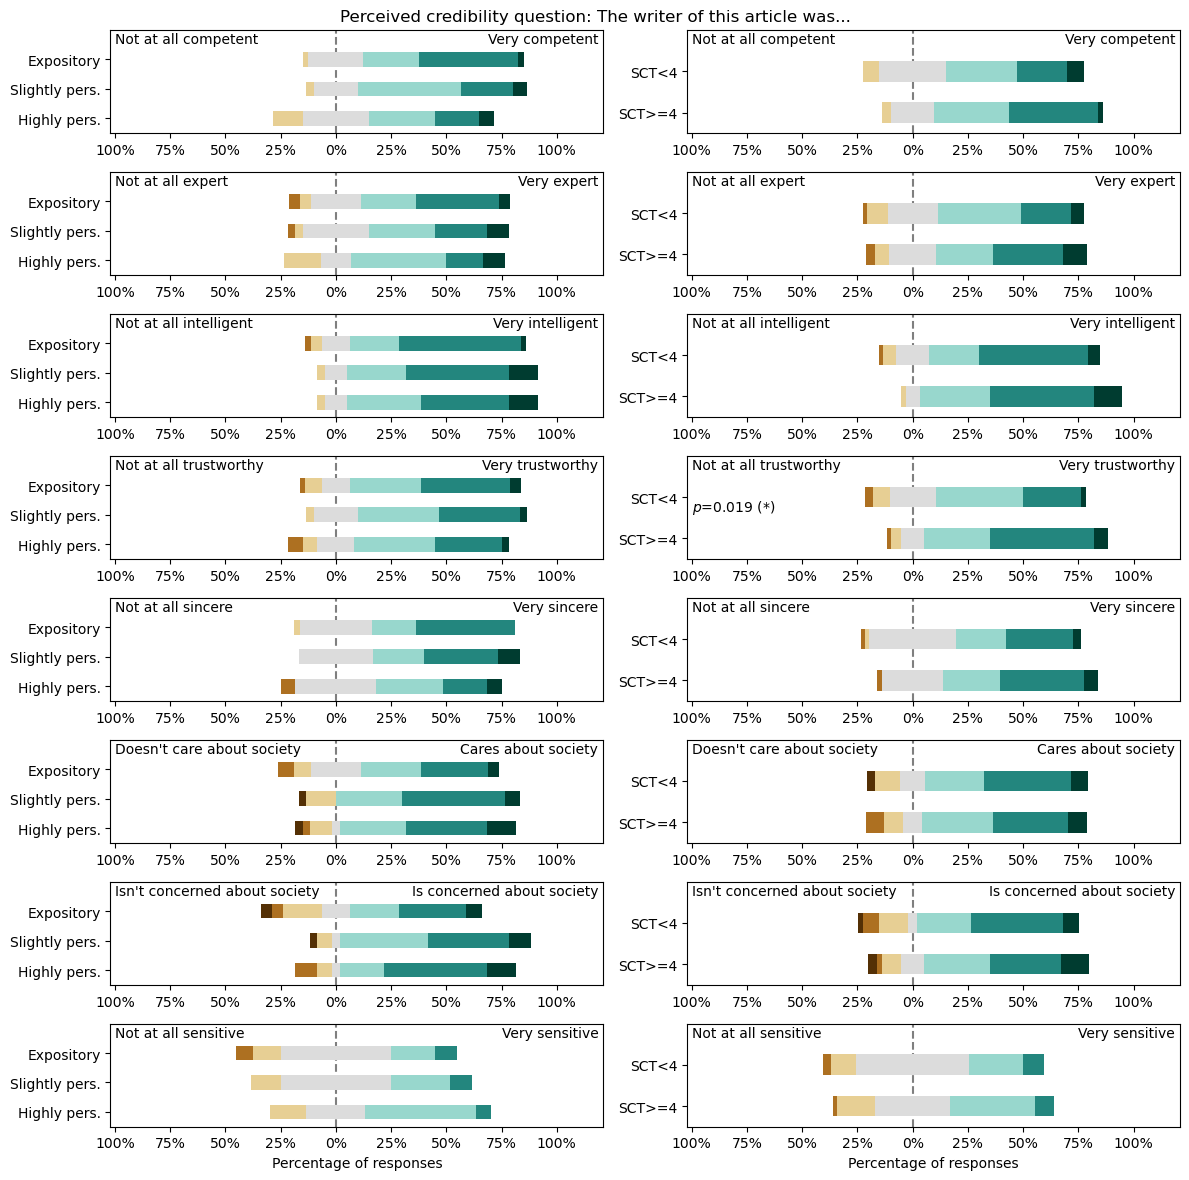

Credibility Cronbach-Alpha: 0.73


In [12]:
# Create Figure 6
fig, ax = plt.subplots(8, len(plot_groupings), figsize=(figwidth, 12))
question = "Q12"
subqs = range(1, 9)

scales = [['Not at all competent', 'Very competent'],
          ['Not at all expert', 'Very expert'],
          ['Not at all intelligent', 'Very intelligent'],
          ['Not at all trustworthy', 'Very trustworthy'],
          ['Not at all sincere', 'Very sincere'],
          ["Doesn't care about society", 'Cares about society'],
          ["Isn't concerned about society", 'Is concerned about society'],
          ['Not at all sensitive', 'Very sensitive']]

cmap = matplotlib.colormaps['BrBG']
colors = ["#ffffff00"] + [cmap(i) for i in np.linspace(0, 1, 7)]
colors[4] = "gainsboro"

for j, condition in enumerate(plot_groupings):
    for i, v in enumerate(subqs):
        if condition == 'SCT_gt4':
            data = pd.DataFrame([df[f"{question}_{v}"].where(df[condition]==b) for b in [False, True]]).T
            data.columns = ['SCT<4', 'SCT>=4']
            maxy =2
        elif condition == 'byplane':
            data = pd.DataFrame([df[f"{question}_{v}"].where(df[condition]==b) for b in [True, False]]).T
            data.columns = ['Plane very likely', 'Others']
            maxy =2
        elif condition == 'Condition':
            data = pd.DataFrame([df[f"{question}_{v}"].where(df["Condition"]==c) for c in range(1, 4)]).T
            data.columns = ['Expository', 'Slightly pers.', 'Highly pers.']
            maxy =3

        plot_likert.plot_likert(data, [1.0, 2.0, 3.0, 4.0, 5.0, 6.0, 7.0], ax=ax[i, j], colors=colors, plot_percentage=True, xtick_interval=25, pad_100=True)

        ax[i, j].set_ylim([-0.5, maxy])
        ax[i, j].text(0.01, 0.98, scales[i][0], transform=ax[i, j].transAxes, ha='left', va='top')
        ax[i, j].text(0.99, 0.98, scales[i][1], transform=ax[i, j].transAxes, ha='right', va='top')
        ax[i, j].get_legend().remove()
        ax[i, j].set_xlabel("")

        aov = pg.anova(dv=f"{question}_{v}", between=condition, data=df, detailed=False)
        pval = aov['p-unc'].mean()
        if pval < 0.05:
            ax[i, j].text(0.01, 0.5, f"$p$={pval:.3f} (*)", transform=ax[i, j].transAxes, ha='left', va='center')
        star = ' (*)' if pval < 0.05 else ''
        print(f"{question}_{v} ({scales[i][0]}/{scales[i][1]}): {pval:.3f}{star}")

        if condition == 'Condition' and pval<0.05:
            pt = pg.pairwise_tests(dv=f"{question}_{v}", between=condition, padjust='holm',
                                alternative='two-sided', data=df)
            for i, row in pt.iterrows():
                pval = row['p-corr']
                star = ' (*)' if pval < 0.05 else ''
                print(f"{Conditions[row['A']]} vs {Conditions[row['B']]}: {pval:.3f}{star}")

    df["Credibility"] = df[[f"{question}_{v}" for v in subqs]].mean(axis=1)
    aov = pg.anova(dv="Credibility", between=condition, data=df, detailed=False)
    pval = aov['p-unc'].mean()
    star = ' (*)' if pval < 0.05 else ''
    print(f"Credibility separated by {condition}: {pval:.3f}{star}")

    ax[-1, j].set_xlabel("Percentage of responses")
plt.suptitle("Perceived credibility question: The writer of this article was...")
plt.tight_layout()
plt.show()

ca = pg.cronbach_alpha(df[[f"{question}_{v}" for v in subqs]])
print(f"Credibility Cronbach-Alpha: {ca[0]:.2f}")

Q13_1 (Not at all competent/Very competent): 0.766
Q13_2 (Not at all expert/Very expert): 0.635
Q13_1 (Not at all competent/Very competent): 0.090
Q13_2 (Not at all expert/Very expert): 0.026 (*)


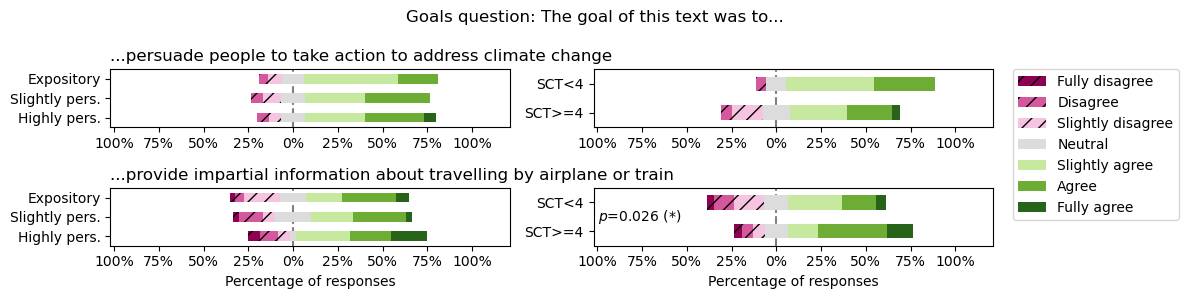

In [13]:
# Create Figure 7
fig, ax = plt.subplots(2, len(plot_groupings), figsize=(figwidth, 3))
question = "Q13"
subqs = range(1, 3)

likert_labels = ['Fully disagree', 'Disagree', 'Slightly disagree', 'Neutral', 'Slightly agree', 'Agree', 'Fully agree']
titles = ['...persuade people to take action to address climate change',
          '...provide impartial information about travelling by airplane or train']

cmap = matplotlib.colormaps['PiYG']
colors = ["#ffffff00"] + [cmap(i) for i in np.linspace(0, 1, 7)]
colors[4] = "gainsboro"

for j, condition in enumerate(plot_groupings):
    for i, v in enumerate(subqs):
        if condition == 'SCT_gt4':
            data = pd.DataFrame([df[f"{question}_{v}"].where(df[condition]==b) for b in [False, True]]).T
            data.columns = ['SCT<4', 'SCT>=4']
            maxy =2
        elif condition == 'byplane':
            data = pd.DataFrame([df[f"{question}_{v}"].where(df[condition]==b) for b in [True, False]]).T
            data.columns = ['Plane very likely', 'Others']
            maxy =2
        elif condition == 'Condition':
            data = pd.DataFrame([df[f"{question}_{v}"].where(df["Condition"]==c) for c in range(1, 4)]).T
            data.columns = ['Expository', 'Slightly pers.', 'Highly pers.']
            maxy =3

        a= plot_likert.plot_likert(data, [1.0, 2.0, 3.0, 4.0, 5.0, 6.0, 7.0], ax=ax[i, j], colors=colors, plot_percentage=True, xtick_interval=25, pad_100=True)
        # adding hatches to the 'negative' bars
        bars = [thing for thing in a.containers if isinstance(thing, matplotlib.container.BarContainer)]
        for bar in bars[1:4]:
            for patch in bar:
                patch.set_hatch("//")

        if j == 0:
            ax[i, j].set_title(titles[i], loc='left')
        ax[i, j].legend().remove()
        ax[i, j].set_xlabel("")

        aov = pg.anova(dv=f"{question}_{v}", between=condition, data=df, detailed=False)
        pval = aov['p-unc'].mean()
        if pval < 0.05:
            ax[i, j].text(0.01, 0.5, f"$p$={pval:.3f} (*)", transform=ax[i, j].transAxes, ha='left', va='center')
        star = ' (*)' if pval < 0.05 else ''
        print(f"{question}_{v} ({scales[i][0]}/{scales[i][1]}): {pval:.3f}{star}")

        if condition == 'Condition' and pval<0.05:
            pt = pg.pairwise_tests(dv=f"{question}_{v}", between=condition, padjust='holm',
                                alternative='two-sided', data=df)
            for i, row in pt.iterrows():
                pval = row['p-corr']
                star = ' (*)' if pval < 0.05 else ''
                print(f"{Conditions[row['A']]} vs {Conditions[row['B']]}: {pval:.3f}{star}")

    ax[-1, j].set_xlabel("Percentage of responses")

handles, labels = ax[0, -1].get_legend_handles_labels()
ax[0, -1].legend(handles, likert_labels, bbox_to_anchor=(1.05, 1), loc='upper left', borderaxespad=0.)

plt.suptitle("Goals question: The goal of this text was to...")
plt.tight_layout()
plt.show()

Q13_3 (Not at all competent/Very competent): 0.263
Q13_4 (Not at all expert/Very expert): 0.041 (*)
Logical scientific vs Slightly personalized: 0.880
Logical scientific vs Highly Personalized: 0.071
Slightly personalized vs Highly Personalized: 0.071
Q13_3 (Not at all competent/Very competent): 0.017 (*)
Q13_4 (Not at all expert/Very expert): 0.128


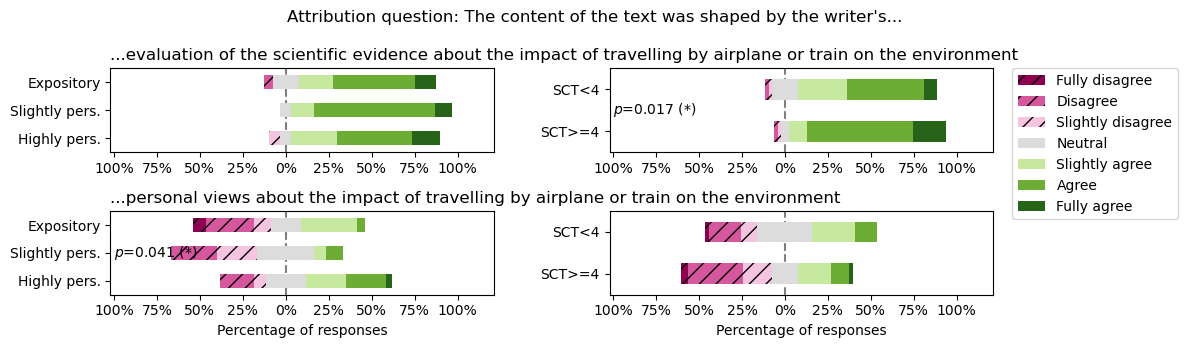

In [14]:
# Create Figure 8
fig, ax = plt.subplots(2, len(plot_groupings), figsize=(figwidth, 3.5))
question = "Q13"
subqs = range(3, 5)

likert_labels = ['Fully disagree', 'Disagree', 'Slightly disagree', 'Neutral', 'Slightly agree', 'Agree', 'Fully agree']
titles = ["...evaluation of the scientific evidence about the impact of travelling by airplane or train on the environment",
          "...personal views about the impact of travelling by airplane or train on the environment"]

cmap = matplotlib.colormaps['PiYG']
colors = ["#ffffff00"] + [cmap(i) for i in np.linspace(0, 1, 7)]
colors[4] = "gainsboro"

for j, condition in enumerate(plot_groupings):
    for i, v in enumerate(subqs):
        if condition == 'SCT_gt4':
            data = pd.DataFrame([df[f"{question}_{v}"].where(df[condition]==b) for b in [False, True]]).T
            data.columns = ['SCT<4', 'SCT>=4']
            maxy =2
        elif condition == 'byplane':
            data = pd.DataFrame([df[f"{question}_{v}"].where(df[condition]==b) for b in [True, False]]).T
            data.columns = ['Plane very likely', 'Others']
            maxy =2
        elif condition == 'Condition':
            data = pd.DataFrame([df[f"{question}_{v}"].where(df["Condition"]==c) for c in range(1, 4)]).T
            data.columns = ['Expository', 'Slightly pers.', 'Highly pers.']
            maxy =3

        a = plot_likert.plot_likert(data, [1.0, 2.0, 3.0, 4.0, 5.0, 6.0, 7.0], ax=ax[i, j], colors=colors, plot_percentage=True, xtick_interval=25, pad_100=True)
        # adding hatches to the 'negative' bars
        bars = [thing for thing in a.containers if isinstance(thing, matplotlib.container.BarContainer)]
        for bar in bars[1:4]:
            for patch in bar:
                patch.set_hatch("//")

        if j == 0:
            ax[i, j].set_title(titles[i], loc='left')
            # fig.text(0.1, 1-i/2., titles[i], ha='left')
            # plt.suptitle(titles[i])
        ax[i, j].legend().remove()
        ax[i, j].set_xlabel("")

        aov = pg.anova(dv=f"{question}_{v}", between=condition, data=df, detailed=False)
        pval = aov['p-unc'].mean()
        if pval < 0.05:
            ax[i, j].text(0.01, 0.5, f"$p$={pval:.3f} (*)", transform=ax[i, j].transAxes, ha='left', va='center')
        star = ' (*)' if pval < 0.05 else ''
        print(f"{question}_{v} ({scales[i][0]}/{scales[i][1]}): {pval:.3f}{star}")

        if condition == 'Condition' and pval<0.05:
            pt = pg.pairwise_tests(dv=f"{question}_{v}", between=condition, padjust='holm',
                                alternative='two-sided', data=df)
            for i, row in pt.iterrows():
                pval = row['p-corr']
                star = ' (*)' if pval < 0.05 else ''
                print(f"{Conditions[row['A']]} vs {Conditions[row['B']]}: {pval:.3f}{star}")

    ax[-1, j].set_xlabel("Percentage of responses")

handles, labels = ax[0, -1].get_legend_handles_labels()
ax[0, -1].legend(handles, likert_labels, bbox_to_anchor=(1.05, 1), loc='upper left', borderaxespad=0.)

plt.suptitle("Attribution question: The content of the text was shaped by the writer's...")
plt.tight_layout()
plt.show()